# Continuous Transformer
What if we take the Transformer to its continuous limit?

In [1]:
# Model settings
DIM = int(1024 * 1.5)
DEPTH = 6
VOCAB_SIZE = 256

# Training settings
BASE_LR = 3e-4
WEIGHT_DECAY = 0.01
BATCH_SIZE = 1
SEQ_LENGTH = int(8192/2)  # Character level
GRAD_CLIP = 1.0

# Checkpoint settings
CHECKPOINT_EVERY = 1000
PRINT_EVERY = 100

# Generation settings
GEN_LENGTH = int(300)
GEN_TEMPERATURE = 0.85
GEN_TOP_P = 0.9

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
import os
import urllib.request
from torch.utils.checkpoint import checkpoint
from tqdm import tqdm
import mmap

In [3]:
def prepare_tinystories_dataset(cache_dir='~/.cache/continuous_transformer'):
    """
    Download TinyStories dataset if needed.
    Returns path to the text file.
    """
    cache_dir = os.path.expanduser(cache_dir)
    os.makedirs(cache_dir, exist_ok=True)
    
    train_path = os.path.join(cache_dir, 'tinystories_train.txt')
    
    if not os.path.exists(train_path):
        print("Downloading TinyStories training data...")
        url = "https://huggingface.co/datasets/roneneldan/TinyStories/resolve/main/TinyStoriesV2-GPT4-train.txt"
        urllib.request.urlretrieve(url, train_path)
        print(f"Downloaded to {train_path}")
    
    file_size = os.path.getsize(train_path)
    print(f"Using dataset: {train_path} ({file_size/1e6:.1f}MB)")
    
    return train_path


class TinyStoriesDataset(Dataset):
    def __init__(self, data_path: str, seq_length: int, stride: int = 512):
        self.data_path = data_path
        self.seq_length = seq_length
        self.stride = stride
        
        # Get file size without loading into memory
        self.file_size = os.path.getsize(data_path)
        
        # Calculate dataset length with stride to reduce overlapping sequences
        self.length = (self.file_size - seq_length - 1) // stride
        
        # Lazy initialization - file opened on first access per worker
        self._file = None
        self._mmap = None
        
    def _ensure_mmap(self):
        """Lazy open file handle - called once per worker process"""
        if self._mmap is None:
            self._file = open(self.data_path, 'rb')  # Binary mode for mmap
            self._mmap = mmap.mmap(self._file.fileno(), 0, access=mmap.ACCESS_READ)
        return self._mmap
    
    def __len__(self) -> int:
        return self.length
    
    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Stream a single sequence from disk
        
        Args:
            idx: Sequence index
            
        Returns:
            x: Input tokens [L]
            y: Target tokens [L]
        """
        # Get mmap (opens file if this is first call in this worker)
        mm = self._ensure_mmap()
        
        # Calculate file position with stride
        pos = idx * self.stride
        
        # Read only what we need from disk
        mm.seek(pos)
        chunk = mm.read(self.seq_length + 1)
        
        # Decode and filter to ASCII
        try:
            text = chunk.decode('utf-8', errors='ignore')
        except:
            text = chunk.decode('latin-1', errors='ignore')
        
        # Keep only ASCII characters
        text = ''.join(c for c in text if ord(c) < 128)
        
        # Pad if needed (near end of file)
        if len(text) < self.seq_length + 1:
            text = text + ' ' * (self.seq_length + 1 - len(text))
        
        # Convert to tokens
        x = torch.tensor([ord(c) for c in text[:self.seq_length]], dtype=torch.long)
        y = torch.tensor([ord(c) for c in text[1:self.seq_length + 1]], dtype=torch.long)
        
        return x, y
    
    def __del__(self):
        """Clean up file handles"""
        if self._mmap is not None:
            self._mmap.close()
        if self._file is not None:
            self._file.close()

In [4]:
# Setup dataset
data_path = prepare_tinystories_dataset()

Using dataset: /home/midori/.cache/continuous_transformer/tinystories_train.txt (2227.8MB)


In [ ]:
class ContinuousTransformer(nn.Module):
    r"""
    Continuous-Time Transformer with Selective Rational Spectral Memory.
    
    This architecture implements a Gated State Space Model (SSM) governed by a 
    continuous-time differential equation, solved analytically in the frequency domain.
    
    Transfer Function:
        H(s, x) = e^{(-λ + iω) \cdot t \cdot \Delta \tau} \cdot \frac{P(s, x)}{|Q(s, x)| + 1}
        
    where P and Q are now content-conditional via spectral gating.
    """
    def __init__(self, dim: int = 1024, depth: int = 6, vocab: int = 256, num_heads: int = 8, use_checkpoint: bool = True):
        super().__init__()
        self.dim = dim
        self.depth = depth
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.use_checkpoint = use_checkpoint
        
        # --- 1. Signal Conditioning (Input Interface) ---
        self.embed = nn.Embedding(vocab, dim)
        
        # Causal Gaussian Kernel for input smoothing
        # Acts as an anti-aliasing filter for the continuous approximation
        smooth_kernel = torch.exp(-0.5 * torch.linspace(0, 2, 5)**2)
        smooth_kernel = smooth_kernel / smooth_kernel.sum()
        self.register_buffer('smooth_kernel', smooth_kernel.view(1, 1, -1).repeat(dim, 1, 1))
        
        self.to_complex = nn.Linear(dim, dim * 2)
        
        # --- 2. System Dynamics (Global Physics) ---
        # Parameters shared across depth to ensure consistent physical laws
        
        # Learnable time-scaling factor (Delta Tau)
        self.dt = nn.Parameter(torch.tensor(1.0))
        
        # Base oscillator parameters
        self.log_lambda = nn.Parameter(torch.linspace(0, -6, num_heads))  # Damping coefficients
        self.omega = nn.Parameter(torch.randn(num_heads, self.head_dim) * 0.1)  # Resonant frequencies
        
        # Rational Transfer Function parameters (Numerator P, Denominator Q)
        # Manifold-aligned parameterization discovered through training:
        # Poles cluster near Re=Im diagonal, so we parameterize in natural coordinates
        # r = radial component along Re=Im diagonal (critical damping line)
        # d = deviation perpendicular to diagonal (fine-tuning Q-factor)
        self.P_radial = nn.Parameter(torch.randn(num_heads, self.head_dim) * 0.02)
        self.P_deviation = nn.Parameter(torch.randn(num_heads, self.head_dim) * 0.01)  # Smaller init for deviation
        self.Q_radial = nn.Parameter(torch.randn(num_heads, self.head_dim) * 0.02)
        self.Q_deviation = nn.Parameter(torch.randn(num_heads, self.head_dim) * 0.01)
        
        # --- 2b. Selective State Modulation (Content-Conditional Poles) ---
        # Spectral gate: Input frequency content → pole/zero offsets
        # This enables Mamba-style selectivity while keeping learnable rational framework
        self.spectral_gate = nn.Sequential(
            nn.Linear(dim, dim),
            nn.GELU(),
            nn.Linear(dim, num_heads * self.head_dim * 4)  # 4 offsets: ΔP_r, ΔP_d, ΔQ_r, ΔQ_d
        )
        
        # --- 3. Layer Architecture ---
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                'in_proj': nn.Linear(dim * 2, 2 * dim),   # Input projection/gate
                'out_gate': nn.Linear(dim * 2, dim),      # Output selection gate
                'out_proj': nn.Linear(dim * 2, dim),      # Output projection
                'norm': nn.LayerNorm(dim)
            }) for _ in range(depth)
        ])
        
        # Depth-dependent bias vectors
        self.depth_biases = nn.ParameterList([
            nn.Parameter(torch.randn(dim) * 0.02) for _ in range(depth)
        ])
        
        self.out_head = nn.Linear(dim, vocab)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass implementing the selective spectral convolution and gated readout.
        
        Args:
            x: Discrete input tokens [Batch, Length]
            
        Returns:
            logits: Next-token probabilities [Batch, Length, Vocab]
            z: Latent continuous state [Batch, Length, Dim]
        """
        B, L = x.shape
        
        # --- A. Signal Smoothing ---
        # Convolve discrete embeddings with Gaussian kernel to approximate continuous signal
        x_emb = self.embed(x) 
        x_liq = torch.nn.functional.conv1d(
            x_emb.permute(0, 2, 1), 
            self.smooth_kernel, 
            groups=self.dim, 
            padding=4
        )[..., :-4].permute(0, 2, 1)
        
        x_orig = x_liq
        z = x_liq
        
        # --- B. Spectral Content Analysis (Selective Modulation) ---
        # Analyze input spectral content to predict pole/zero offsets
        z_freq = torch.fft.rfft(z, dim=1)
        spectral_energy = torch.abs(z_freq).mean(dim=1)  # [B, Dim]
        
        # Predict pole modulation from spectral signature
        pole_modulation = self.spectral_gate(spectral_energy)  # [B, num_heads * head_dim * 4]
        pole_modulation = pole_modulation.view(B, self.num_heads, self.head_dim, 4)
        
        # Extract bounded offsets (tanh keeps changes small for stability)
        ΔP_r = torch.tanh(pole_modulation[..., 0]) * 0.02  # [B, heads, head_dim]
        ΔP_d = torch.tanh(pole_modulation[..., 1]) * 0.01
        ΔQ_r = torch.tanh(pole_modulation[..., 2]) * 0.02
        ΔQ_d = torch.tanh(pole_modulation[..., 3]) * 0.01
        
        # Average across batch for this forward pass (maintains [heads, head_dim] shape)
        ΔP_r_avg = ΔP_r.mean(dim=0)
        ΔP_d_avg = ΔP_d.mean(dim=0)
        ΔQ_r_avg = ΔQ_r.mean(dim=0)
        ΔQ_d_avg = ΔQ_d.mean(dim=0)
        
        # --- C. Selective Transfer Function Construction ---
        # Compute the frequency response with content-conditional poles
        n_fft = 2 * L
        
        # Physical time axis scaled by learnable dt
        t_axis = torch.arange(n_fft, device=x.device, dtype=torch.float32) * self.dt.abs()
        
        # 1. Base Exponential Kernel (Damped Oscillator)
        decay = torch.exp(self.log_lambda).view(self.num_heads, 1, 1)
        freq = self.omega.view(self.num_heads, 1, self.head_dim)
        base_kernel = torch.exp((-decay + 1j * freq) * t_axis.view(1, -1, 1))
        BASE_FREQ = torch.fft.fft(base_kernel, n=n_fft, dim=1)
        
        # 2. Selective Rational Modulation (Content-Conditional Poles)
        # Apply dynamic offsets to base parameters
        P_radial_dynamic = self.P_radial + ΔP_r_avg
        P_deviation_dynamic = self.P_deviation + ΔP_d_avg
        Q_radial_dynamic = self.Q_radial + ΔQ_r_avg
        Q_deviation_dynamic = self.Q_deviation + ΔQ_d_avg
        
        # Transform manifold coordinates to Cartesian for transfer function
        # r, d → (real, imag) via 45° rotation to align with discovered geometry
        sqrt2_inv = 0.7071067811865476  # 1/sqrt(2)
        P_real = (P_radial_dynamic + P_deviation_dynamic) * sqrt2_inv
        P_imag = (P_radial_dynamic - P_deviation_dynamic) * sqrt2_inv
        Q_real = (Q_radial_dynamic + Q_deviation_dynamic) * sqrt2_inv
        Q_imag = (Q_radial_dynamic - Q_deviation_dynamic) * sqrt2_inv
        
        P = torch.complex(P_real, P_imag).view(self.num_heads, 1, -1)
        Q = torch.complex(Q_real, Q_imag).view(self.num_heads, 1, -1)
        RATIONAL_MOD = P / (torch.abs(Q) + 1.0)
        
        # Final System Transfer Function (now content-dependent!)
        SYSTEM_KERNEL = BASE_FREQ * RATIONAL_MOD
        
        def process_layer(z, layer, depth_bias, SYSTEM_KERNEL):
            """Process a single layer - wrapped for gradient checkpointing"""
            # Inject depth bias
            z = z + depth_bias
            
            # Map to complex state space
            z_raw = self.to_complex(z)
            z_c = torch.complex(z_raw[..., :self.dim], z_raw[..., self.dim:])
            x_in = torch.cat([z_c.real, z_c.imag], dim=-1)
            
            # 1. Input Gating (Forcing Function)
            u, g = layer['in_proj'](x_in).chunk(2, dim=-1)
            impulse = u * torch.sigmoid(g)
            
            # 2. Spectral Convolution (Memory Update)
            # Y(s) = X(s) * H(s, x) via FFT
            impulse = impulse.view(B, L, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
            IMPULSE = torch.fft.fft(torch.complex(impulse, torch.zeros_like(impulse)), n=n_fft, dim=2)
            
            # Apply Transfer Function
            memory = torch.fft.ifft(IMPULSE * SYSTEM_KERNEL, n=n_fft, dim=2)[:, :, :L, :]
            
            # 3. Output Gating (Readout)
            mem_flat = memory.permute(0, 2, 1, 3).reshape(B, L, self.dim)
            mem_norm = torch.cat([layer['norm'](mem_flat.real), layer['norm'](mem_flat.imag)], dim=-1)
            
            content = layer['out_proj'](mem_norm)
            gate = torch.sigmoid(layer['out_gate'](x_in))
            
            z_out = content * gate
            
            # Residual Connection
            return z + z_out * 0.1
        
        # --- D. Deep Recurrent Pass ---
        for i, layer in enumerate(self.layers):
            if self.use_checkpoint and self.training:
                z = checkpoint(process_layer, z, layer, self.depth_biases[i], SYSTEM_KERNEL, use_reentrant=False)
            else:
                z = process_layer(z, layer, self.depth_biases[i], SYSTEM_KERNEL)
        
        # --- E. Projection ---
        # Skip connection from original signal preserves high-frequency input details
        logits = self.out_head(z + x_orig * 0.1)
        
        return logits, z


<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_48041/1072098455.py:9: SyntaxWarning: invalid escape sequence '\c'
  H(s, x) = e^{(-λ + iω) \cdot t \cdot \Delta \tau} \cdot \frac{P(s, x)}{|Q(s, x)| + 1}


In [6]:
@torch.no_grad()
def generate(model: nn.Module, prompt: str, device: str = 'cuda') -> None:
    """
    Autoregressive text generation.
    
    Args:
        model: Trained ContinuousTransformer instance
        prompt: Initial text prompt
        device: Computation device
    """
    model.eval()
    tokens = [ord(c) for c in prompt]
    print(f"\nGeneration: {prompt}", end="", flush=True)
    
    for _ in range(GEN_LENGTH):
        # Use consistent sequence length
        ctx = torch.tensor([tokens[-SEQ_LENGTH:]], device=device)
        logits, _ = model(ctx)  # [1, L, V]
        
        # Nucleus (top-p) sampling
        probs = torch.softmax(logits[0, -1] / GEN_TEMPERATURE, dim=-1)  # [V]
        sorted_probs, idx = torch.sort(probs, descending=True)
        cumsum = torch.cumsum(sorted_probs, dim=0)
        cutoff = (cumsum > GEN_TOP_P).float()
        cutoff[1:] = cutoff[:-1].clone()
        cutoff[0] = 0
        probs[idx[cutoff.bool()]] = 0
        probs = probs / probs.sum()  # Renormalize
        
        next_token = torch.multinomial(probs, 1).item()
        tokens.append(next_token)
        print(chr(next_token), end="", flush=True)
    
    print("\n")
    model.train()

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import colorsys

def complex_to_rgb(z):
    """
    Converts a grid of complex numbers into an RGB image using Domain Coloring.
    - Hue represents the complex phase (angle)
    - Brightness represents the magnitude
    """
    r = np.abs(z)
    arg = np.angle(z)
    
    # Enhanced contrast using power scaling
    # This makes the structure more visible
    r_norm = r / (np.percentile(r, 95) + 1e-8)
    r_norm = np.clip(r_norm, 0, 1)
    r_norm = r_norm ** 0.5  # Square root for better contrast
    
    # Map phase to hue (0 to 1)
    h = (arg + np.pi) / (2 * np.pi)
    s = 0.95  # High saturation for vibrant colors
    v = 0.3 + 0.7 * r_norm  # Avoid pure black
    
    # Convert HSV to RGB
    c = np.vectorize(colorsys.hsv_to_rgb)(h, s, v)
    c = np.array(c).transpose(1, 2, 0)
    return c

@torch.no_grad()
def visualize_spectral_dynamics(model: nn.Module, device: str = 'cuda', seq_len: int = 512):
    """
    Visualize the learned rational memory landscape using domain coloring.
    Shows poles (bright spots), zeros (dark spots), and phase structure (colors).
    """
    model.eval()
    
    # Get P/Q statistics
    with torch.no_grad():
        # Transform manifold coordinates back to Cartesian for visualization
        sqrt2_inv = 0.7071067811865476
        P_real = (model.P_radial + model.P_deviation) * sqrt2_inv
        P_imag = (model.P_radial - model.P_deviation) * sqrt2_inv
        Q_real = (model.Q_radial + model.Q_deviation) * sqrt2_inv
        Q_imag = (model.Q_radial - model.Q_deviation) * sqrt2_inv
        
        P_mag = torch.sqrt(P_real**2 + P_imag**2).mean(dim=1).cpu().numpy()
        Q_mag = torch.sqrt(Q_real**2 + Q_imag**2).mean(dim=1).cpu().numpy()
        pq_ratios = P_mag / (Q_mag + 1e-6)
    
    # Find most hyperbolic head
    most_hyperbolic_head = np.argmin(pq_ratios)
    
    fig = plt.figure(figsize=(20, 15))
    
    # Left side: Julia-style memory landscapes for multiple heads
    for i, head_idx in enumerate([most_hyperbolic_head, 0, model.num_heads-1]):
        ax = plt.subplot(3, 4, i+1)
        
        # Get P and Q for this head (all dimensions)
        sqrt2_inv = 0.7071067811865476
        P_real = (model.P_radial[head_idx] + model.P_deviation[head_idx]) * sqrt2_inv
        P_imag = (model.P_radial[head_idx] - model.P_deviation[head_idx]) * sqrt2_inv
        Q_real = (model.Q_radial[head_idx] + model.Q_deviation[head_idx]) * sqrt2_inv
        Q_imag = (model.Q_radial[head_idx] - model.Q_deviation[head_idx]) * sqrt2_inv
        
        P_complex = torch.complex(P_real, P_imag).cpu().numpy()
        Q_complex = torch.complex(Q_real, Q_imag).cpu().numpy()
        
        # Determine domain from actual pole/zero distribution
        all_points = np.concatenate([P_complex, Q_complex])
        center_real = np.mean(all_points.real)
        center_imag = np.mean(all_points.imag)
        
        # Set zoom based on spread of poles/zeros
        spread_real = np.max(all_points.real) - np.min(all_points.real)
        spread_imag = np.max(all_points.imag) - np.min(all_points.imag)
        zoom = max(spread_real, spread_imag) * 0.6  # 60% of spread
        
        resolution = 1200  # Higher resolution for fine detail
        x = np.linspace(center_real - zoom, center_real + zoom, resolution)
        y = np.linspace(center_imag - zoom, center_imag + zoom, resolution)
        X, Y = np.meshgrid(x, y)
        Z = X + 1j * Y
        
        # Apply rational transfer function using first dimension for functional form
        P_c = P_complex[0]
        Q_c = Q_complex[0]
        epsilon = 1e-10
        denominator = Q_c * Z + 1.0
        W = P_c / (denominator + epsilon * (1 + 1j))
        
        # Convert to RGB
        img = complex_to_rgb(W)
        ax.imshow(img, extent=[center_real-zoom, center_real+zoom, 
                              center_imag-zoom, center_imag+zoom], origin='lower')
        
        # Overlay actual pole/zero locations from the scatter plot
        ax.scatter(P_complex.real, P_complex.imag, s=20, marker='o', 
                  c='yellow', edgecolors='black', linewidth=0.5, alpha=0.8, label='Zeros')
        ax.scatter(Q_complex.real, Q_complex.imag, s=30, marker='x', 
                  c='white', linewidth=1.5, alpha=0.9, label='Poles')
        
        geometry = "Hyperbolic" if pq_ratios[head_idx] < 1.0 else "Spherical"
        ax.set_title(f'Head {head_idx} Memory Landscape\n{geometry} (P/Q={pq_ratios[head_idx]:.3f})', 
                    fontsize=11, fontweight='bold')
        ax.set_xlabel('Real', fontsize=9)
        ax.set_ylabel('Imaginary', fontsize=9)
        ax.grid(False)
    
    # Right side: Statistical plots
    
    # 1. P/Q Ratio per Head
    ax = plt.subplot(3, 4, 4)
    colors = plt.cm.viridis(np.linspace(0, 1, len(pq_ratios)))
    bars = ax.bar(range(len(pq_ratios)), pq_ratios, color=colors, edgecolor='black', linewidth=1.5)
    ax.axhline(1.0, color='red', linewidth=2, linestyle='--', label='Euclidean')
    ax.set_xlabel('Head Index', fontsize=10)
    ax.set_ylabel('P/Q Ratio', fontsize=10)
    ax.set_title('Memory Geometry Distribution', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Highlight most hyperbolic
    bars[most_hyperbolic_head].set_edgecolor('red')
    bars[most_hyperbolic_head].set_linewidth(3)
    
    # 2. Transfer Function Magnitude
    ax = plt.subplot(3, 4, 5)
    n_fft = 2 * seq_len
    t_axis = torch.arange(n_fft, device=device, dtype=torch.float32) * model.dt.abs().item()
    decay = torch.exp(model.log_lambda).view(model.num_heads, 1, 1)
    freq = model.omega.view(model.num_heads, 1, model.head_dim)
    base_kernel = torch.exp((-decay + 1j * freq) * t_axis.view(1, -1, 1))
    BASE_FREQ = torch.fft.fft(base_kernel, n=n_fft, dim=1)
    
    # Transform manifold coords to Cartesian
    sqrt2_inv = 0.7071067811865476
    P_real = (model.P_radial + model.P_deviation) * sqrt2_inv
    P_imag = (model.P_radial - model.P_deviation) * sqrt2_inv
    Q_real = (model.Q_radial + model.Q_deviation) * sqrt2_inv
    Q_imag = (model.Q_radial - model.Q_deviation) * sqrt2_inv
    
    P = torch.complex(P_real, P_imag).view(model.num_heads, 1, model.head_dim)
    Q = torch.complex(Q_real, Q_imag).view(model.num_heads, 1, model.head_dim)
    RATIONAL_MOD = P / (torch.abs(Q) + 1.0)
    H = BASE_FREQ * RATIONAL_MOD
    
    H_mag = torch.abs(H[most_hyperbolic_head, :seq_len, 0]).cpu().numpy()
    freqs = np.fft.fftfreq(n_fft, d=model.dt.abs().item())[:seq_len]
    ax.plot(freqs, H_mag, linewidth=2, color='#2E86AB')
    ax.set_xlabel('Frequency (Hz)', fontsize=10)
    ax.set_ylabel('Magnitude |H(ω)|', fontsize=10)
    ax.set_title(f'Transfer Function (Head {most_hyperbolic_head})', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # 3. Pole-Zero Plot
    ax = plt.subplot(3, 4, 6)
    sqrt2_inv = 0.7071067811865476
    P_real = (model.P_radial[most_hyperbolic_head] + model.P_deviation[most_hyperbolic_head]) * sqrt2_inv
    P_imag = (model.P_radial[most_hyperbolic_head] - model.P_deviation[most_hyperbolic_head]) * sqrt2_inv
    Q_real = (model.Q_radial[most_hyperbolic_head] + model.Q_deviation[most_hyperbolic_head]) * sqrt2_inv
    Q_imag = (model.Q_radial[most_hyperbolic_head] - model.Q_deviation[most_hyperbolic_head]) * sqrt2_inv
    
    P_complex = torch.complex(P_real, P_imag).cpu().numpy()
    Q_complex = torch.complex(Q_real, Q_imag).cpu().numpy()
    
    ax.scatter(P_complex.real, P_complex.imag, s=80, marker='o', 
               c='#F18F01', edgecolors='black', linewidth=1.5, label='Zeros (P)', alpha=0.7)
    ax.scatter(Q_complex.real, Q_complex.imag, s=80, marker='x', 
               c='#C73E1D', linewidth=2.5, label='Poles (Q)', alpha=0.7)
    
    # Add Re=Im diagonal line to show natural manifold
    lim = max(abs(P_complex.real).max(), abs(P_complex.imag).max(),
              abs(Q_complex.real).max(), abs(Q_complex.imag).max()) * 1.2
    ax.plot([-lim, lim], [-lim, lim], 'g--', linewidth=1, alpha=0.5, label='Re=Im (Critical Damping)')
    
    ax.axhline(0, color='gray', linewidth=0.5, linestyle='--')
    ax.axvline(0, color='gray', linewidth=0.5, linestyle='--')
    ax.set_xlabel('Real', fontsize=10)
    ax.set_ylabel('Imaginary', fontsize=10)
    ax.set_title(f'Pole-Zero Distribution (Head {most_hyperbolic_head})', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    # 4. Memory Kernel Time Domain
    ax = plt.subplot(3, 4, 7)
    kernel_time = torch.fft.ifft(H[most_hyperbolic_head, :, 0], n=n_fft).cpu().numpy()
    t_plot = t_axis[:seq_len].cpu().numpy()
    ax.plot(t_plot, np.abs(kernel_time[:seq_len]), linewidth=2, color='#06A77D')
    ax.set_xlabel('Time (dt units)', fontsize=10)
    ax.set_ylabel('|Memory Kernel|', fontsize=10)
    ax.set_title('Memory Kernel (Time Domain)', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # 5. Frequency Distribution
    ax = plt.subplot(3, 4, 8)
    omega_vals = model.omega[most_hyperbolic_head].cpu().numpy()
    ax.hist(omega_vals, bins=30, color='#6A4C93', edgecolor='black', linewidth=1.2, alpha=0.8)
    ax.set_xlabel('Frequency ω', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.set_title('Learned Frequencies', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # # 6. Semantic Basin Visualization (COMMENTED OUT - SLOW)
    # ax = plt.subplot(3, 4, 9)
    # print("Computing semantic basins...")
    # 
    # # Sample complex plane using manifold coordinates
    # resolution = 150
    # r_range = np.linspace(-0.15, 0.15, resolution)
    # d_range = np.linspace(-0.08, 0.08, resolution)
    # R, D = np.meshgrid(r_range, d_range)
    # 
    # # Create dummy input for forward pass
    # dummy_input = torch.randint(0, 256, (1, seq_len), device=device)
    # 
    # # Store original parameters
    # original_P_r = model.P_radial[most_hyperbolic_head].clone()
    # original_P_d = model.P_deviation[most_hyperbolic_head].clone()
    # 
    # # Sample predictions across parameter space
    # predicted_chars = np.zeros((resolution, resolution), dtype=np.int32)
    # entropies = np.zeros((resolution, resolution))
    # 
    # for i in range(resolution):
    #     for j in range(resolution):
    #         # Perturb parameters
    #         with torch.no_grad():
    #             model.P_radial[most_hyperbolic_head].fill_(R[i, j])
    #             model.P_deviation[most_hyperbolic_head].fill_(D[i, j])
    #         
    #         # Get prediction
    #         with torch.no_grad():
    #             logits, _ = model(dummy_input)
    #             probs = torch.softmax(logits[0, -1], dim=-1)
    #             
    #             # Most likely character
    #             predicted_chars[i, j] = probs.argmax().item()
    #             
    #             # Entropy for uncertainty
    #             entropy = -(probs * torch.log(probs + 1e-10)).sum()
    #             entropies[i, j] = entropy.item()
    # 
    # # Restore original parameters
    # with torch.no_grad():
    #     model.P_radial[most_hyperbolic_head].copy_(original_P_r)
    #     model.P_deviation[most_hyperbolic_head].copy_(original_P_d)
    # 
    # # Visualize semantic basins
    # im = ax.imshow(predicted_chars, extent=[r_range[0], r_range[-1], d_range[0], d_range[-1]],
    #                origin='lower', cmap='tab20', interpolation='nearest', alpha=0.8)
    # 
    # # Overlay original parameter positions
    # ax.scatter(original_P_r.cpu().numpy(), original_P_d.cpu().numpy(), 
    #           s=15, c='red', marker='+', linewidths=2, alpha=0.6)
    # 
    # ax.set_xlabel('Radial (r)', fontsize=10)
    # ax.set_ylabel('Deviation (d)', fontsize=10)
    # ax.set_title(f'Semantic Basins (Head {most_hyperbolic_head})', fontsize=11, fontweight='bold')
    # ax.grid(True, alpha=0.2, color='white', linewidth=0.5)
    # 
    # # 7. Entropy Map (Decision Uncertainty)
    # ax = plt.subplot(3, 4, 10)
    # 
    # im = ax.imshow(entropies, extent=[r_range[0], r_range[-1], d_range[0], d_range[-1]],
    #                origin='lower', cmap='viridis', interpolation='bilinear')
    # 
    # # Overlay contour lines for decision boundaries
    # contours = ax.contour(R, D, entropies, levels=8, colors='white', linewidths=0.5, alpha=0.5)
    # 
    # # Overlay original parameter positions
    # ax.scatter(original_P_r.cpu().numpy(), original_P_d.cpu().numpy(), 
    #           s=15, c='red', marker='+', linewidths=2, alpha=0.6)
    # 
    # plt.colorbar(im, ax=ax, label='Entropy')
    # ax.set_xlabel('Radial (r)', fontsize=10)
    # ax.set_ylabel('Deviation (d)', fontsize=10)
    # ax.set_title('Decision Uncertainty Map', fontsize=11, fontweight='bold')
    # ax.grid(True, alpha=0.2, color='white', linewidth=0.5)
    
    plt.suptitle('Continuous Transformer: Rational Memory Landscape', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    model.train()
    

# Training

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Create dataset and dataloader
dataset = TinyStoriesDataset(data_path, seq_length=SEQ_LENGTH)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize model
print("Initializing Continuous Transformer")
model = ContinuousTransformer(dim=DIM, depth=DEPTH, vocab=VOCAB_SIZE).to(device)

params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {params/1e6:.2f}M")

Device: cuda
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Initializing Continuous Transformer
Parameters: 130.63M


In [9]:
# Checkpoint restoration
import glob

checkpoints = glob.glob("continuous_transformer_step*.pt")

if checkpoints:
    steps = [int(cp.split("step")[1].split(".")[0]) for cp in checkpoints]
    latest_step = max(steps)
    latest_checkpoint = f"continuous_transformer_step{latest_step:05d}.pt"
    print(f"Loading checkpoint: {latest_checkpoint}")
    try:
        model.load_state_dict(torch.load(latest_checkpoint, map_location=device))
        start_step = latest_step
        print(f"Resuming from step {start_step}")
    except Exception as e:
        print(f"Warning: Could not load checkpoint ({e}). Starting fresh.")
        start_step = 0
else:
    start_step = 0
    print("No checkpoint found. Starting fresh training.")

# Optimizer with homeostatic learning rate control
opt = optim.AdamW(model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY)
ema_loss = None

Loading checkpoint: continuous_transformer_step50220.pt
Resuming from step 50220


Step 50300 (Epoch 0, Batch 50300/4351072) | Loss: 0.5018 | Acc: 83.5% | LR: 1.83e-04 | dt: 1.291 | P/Q: 0.342
Step 50400 (Epoch 0, Batch 50400/4351072) | Loss: 0.4650 | Acc: 85.0% | LR: 1.90e-04 | dt: 1.291 | P/Q: 0.347
Step 50500 (Epoch 0, Batch 50500/4351072) | Loss: 0.4647 | Acc: 85.2% | LR: 1.83e-04 | dt: 1.290 | P/Q: 0.350
Step 50600 (Epoch 0, Batch 50600/4351072) | Loss: 0.5738 | Acc: 81.4% | LR: 1.82e-04 | dt: 1.291 | P/Q: 0.352
Step 50700 (Epoch 0, Batch 50700/4351072) | Loss: 0.4755 | Acc: 85.2% | LR: 1.81e-04 | dt: 1.292 | P/Q: 0.353
Step 50800 (Epoch 0, Batch 50800/4351072) | Loss: 0.5039 | Acc: 83.3% | LR: 1.91e-04 | dt: 1.290 | P/Q: 0.355
Step 50900 (Epoch 0, Batch 50900/4351072) | Loss: 0.4554 | Acc: 85.1% | LR: 1.86e-04 | dt: 1.290 | P/Q: 0.356
Step 51000 (Epoch 0, Batch 51000/4351072) | Loss: 0.5348 | Acc: 83.1% | LR: 1.69e-04 | dt: 1.290 | P/Q: 0.357

Generation: Once upon a time, there was a mommy and a big park. Mommy and baby brother loved to play in the park. The m

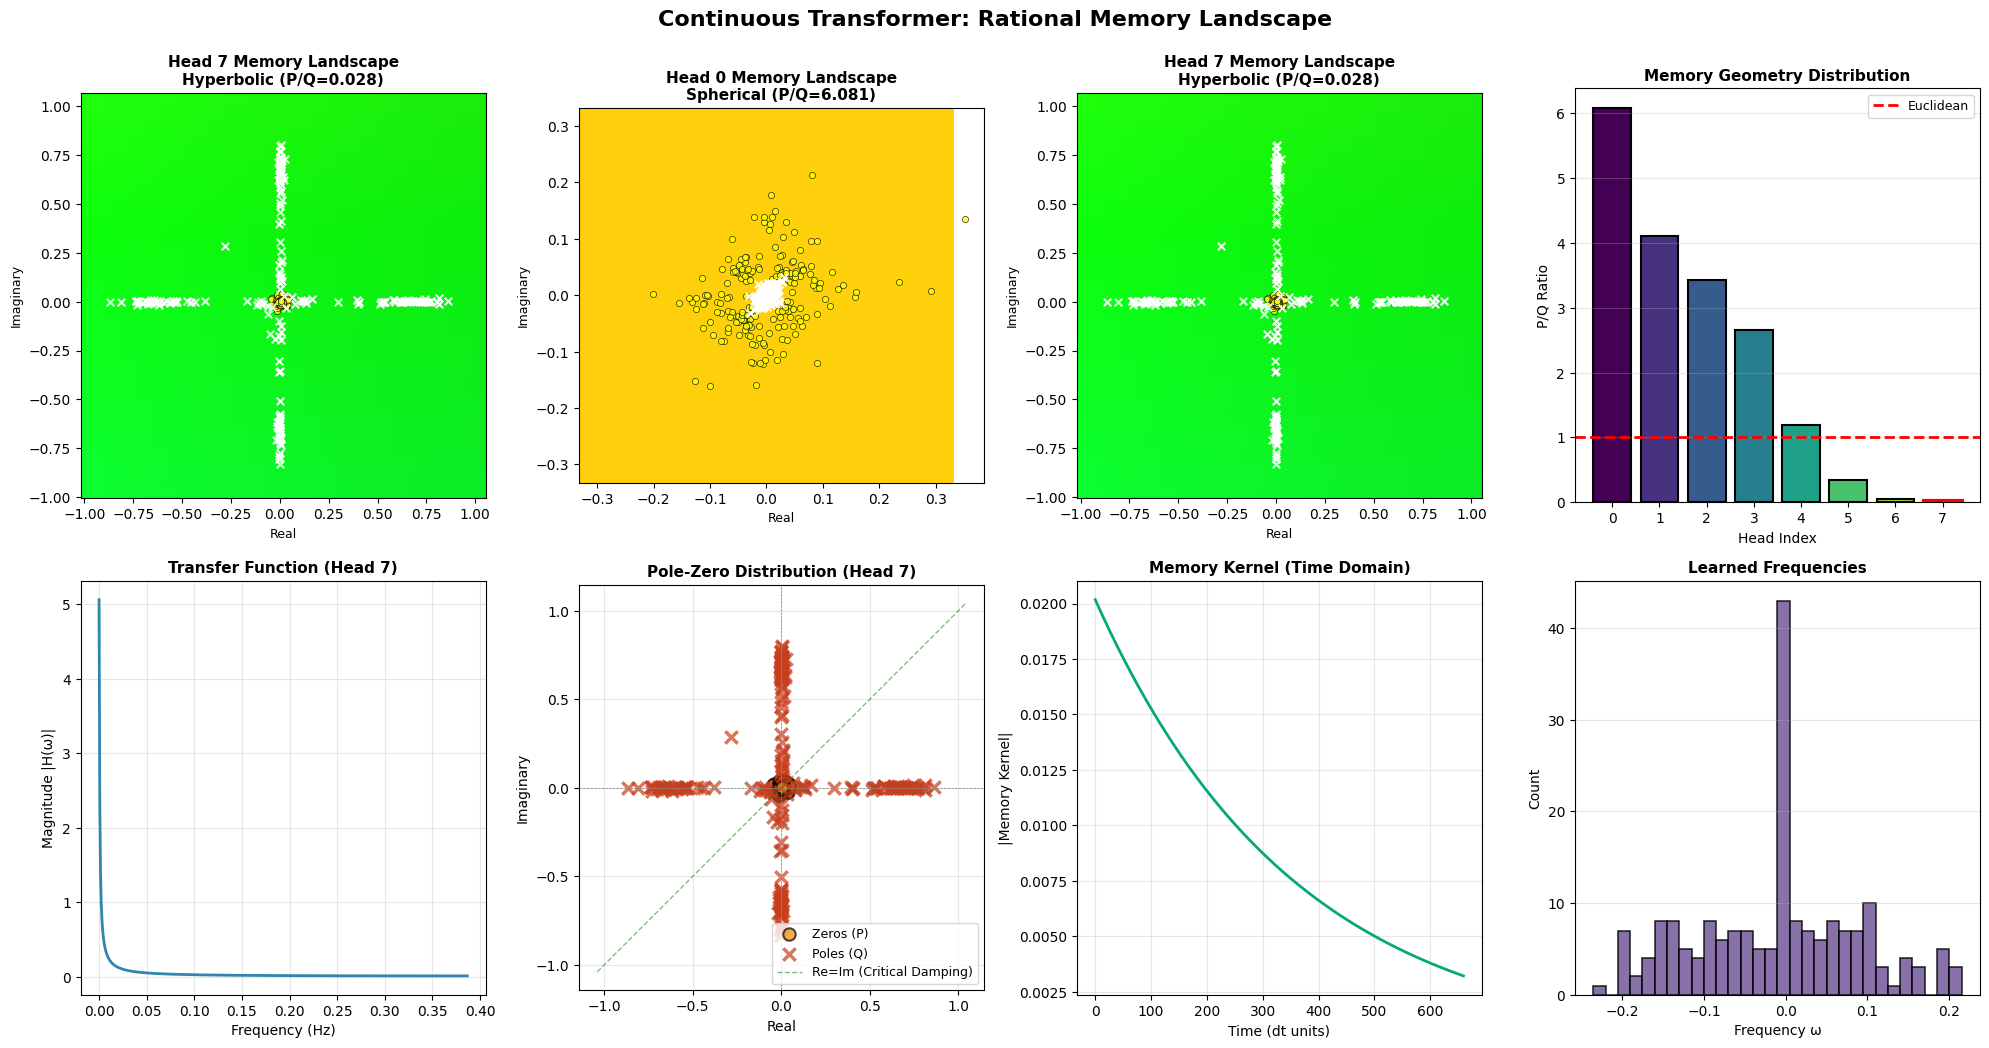

  Checkpoint saved: continuous_transformer_step51000.pt

Step 51100 (Epoch 0, Batch 51100/4351072) | Loss: 0.5698 | Acc: 82.0% | LR: 1.78e-04 | dt: 1.290 | P/Q: 0.359
Step 51200 (Epoch 0, Batch 51200/4351072) | Loss: 0.5218 | Acc: 82.8% | LR: 1.76e-04 | dt: 1.288 | P/Q: 0.360


In [ ]:
step = start_step
try:
    while True:
        for batch_idx, (x, y) in enumerate(dataloader):
            x = x.to(device)  # [B, L]
            y = y.to(device)  # [B, L]
            
            # Forward pass
            logits, _ = model(x)  # [B, L, V]
            loss = nn.CrossEntropyLoss()(logits.view(-1, VOCAB_SIZE), y.view(-1))
            
            # Backward pass
            opt.zero_grad()
            loss.backward()
            
            # Homeostatic learning rate adjustment
            with torch.no_grad():
                # Compute gradient statistics
                grad_norm = sum(p.grad.norm()**2 for p in model.parameters() if p.grad is not None)**0.5
                
                # Update exponential moving average of loss
                if ema_loss is None: 
                    ema_loss = loss.item()
                ema_loss = 0.95 * ema_loss + 0.05 * loss.item()
                
                # Adaptive learning rate based on gradient stability
                stability = 1.0 / (grad_norm.item() + 1e-6)
                reactive_lr = BASE_LR / (1.0 + np.exp(-(stability - 0.5)))
                
                # Update optimizer learning rate
                for param_group in opt.param_groups:
                    param_group['lr'] = reactive_lr
            
            # Gradient clipping and optimization step
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            opt.step()
            
            # Logging
            if step % PRINT_EVERY == 0:
                acc = (logits.argmax(-1) == y).float().mean()
                epoch = step // len(dataloader)
                batch_in_epoch = step % len(dataloader)
                
                # Track P/Q ratio
                with torch.no_grad():
                    sqrt2_inv = 0.7071067811865476
                    P_real = (model.P_radial + model.P_deviation) * sqrt2_inv
                    P_imag = (model.P_radial - model.P_deviation) * sqrt2_inv
                    Q_real = (model.Q_radial + model.Q_deviation) * sqrt2_inv
                    Q_imag = (model.Q_radial - model.Q_deviation) * sqrt2_inv
                    P_mag = (P_real**2 + P_imag**2).sqrt().mean().item()
                    Q_mag = (Q_real**2 + Q_imag**2).sqrt().mean().item()
                    curvature = P_mag / (Q_mag + 1e-6)
                
                print(f"Step {step:05d} (Epoch {epoch}, Batch {batch_in_epoch}/{len(dataloader)}) | Loss: {loss.item():.4f} | Acc: {acc.item()*100:.1f}% | LR: {reactive_lr:.2e} | dt: {model.dt.item():.3f} | P/Q: {curvature:.3f}")
            
            # Checkpointing and generation
            if step % CHECKPOINT_EVERY == 0 and step > start_step:
                generate(model, "Once upon a time", device=device)
                
                # Visualize spectral dynamics
                print("\n" + "="*60)
                print("ANALYZING SPECTRAL DYNAMICS...")
                print("="*60)
                visualize_spectral_dynamics(model, device=device, seq_len=512)
                
                torch.save(model.state_dict(), f"continuous_transformer_step{step:05d}.pt")
                print(f"  Checkpoint saved: continuous_transformer_step{step:05d}.pt\n")
            
            step += 1
        
except KeyboardInterrupt:
    print("\nTraining interrupted by user")
    print(f"Final step: {step}")
    
    # Save final checkpoint
    final_checkpoint = f"continuous_transformer_step{step:05d}.pt"
    torch.save(model.state_dict(), final_checkpoint)
    print(f"Final checkpoint saved: {final_checkpoint}")

## References

- **A Mathematical Explanation of Transformers for Large Language Models and GPTs** - Tai et al. (2024). [arXiv:2510.03989](https://arxiv.org/abs/2510.03989)
- **HiPPO: Recurrent Memory with Optimal Polynomial Projections** - Gu et al. (2020). NeurIPS. [arXiv:2008.07669](https://arxiv.org/abs/2008.07669)
- **Efficiently Modeling Long Sequences with Structured State Spaces (S4)** - Gu et al. (2022). ICLR. [arXiv:2111.00396](https://arxiv.org/abs/2111.00396)
- **Neural Ordinary Differential Equations** - Chen et al. (2018). NeurIPS. [arXiv:1806.07366](https://arxiv.org/abs/1806.07366)
- **Deep Complex Networks** - Trabelsi et al. (2017). ICLR. [arXiv:1705.09792](https://arxiv.org/abs/1705.09792)
- **FNet: Mixing Tokens with Fourier Transforms** - Lee-Thorp et al. (2021). NAACL. [arXiv:2105.03824](https://arxiv.org/abs/2105.03824)
- **Language Modeling with Gated Convolutional Networks** - Dauphin et al. (2017). ICML. [arXiv:1612.08083](https://arxiv.org/abs/1612.08083)
- **Informer: Beyond Efficient Transformer for Long Sequence Time-Series Forecasting** - Zhou et al. (2021). AAAI. [arXiv:2012.07436](https://arxiv.org/abs/2012.07436)
- **Liquid Time-constant Networks** - Hasani et al. (2020). AAAI. [arXiv:2006.04439](https://arxiv.org/abs/2006.04439)
- **TinyStories: How Small Can Language Models Be and Still Speak Coherent English?** - Eldan & Li (2023). [arXiv:2305.07759](https://arxiv.org/abs/2305.07759)